In [1]:
import sys
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
import torch
from torch.utils import model_zoo
from collections import OrderedDict

sys.path.append('../src')
sys.path.append('../src')
from utils import DataHandler
import factory

In [2]:
dh = DataHandler()

In [3]:
def GradCam(img, c, feature_fn, classifier_fn):
    feats = feature_fn(img)
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal)
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


def concat_tiles(image_list):
    image = []
    row_num = int(np.sqrt(len(image_list)))

    for i in range(row_num):
        v = [image_list[(row_num * i) + j] for j in range(row_num)]
        image.append(cv2.hconcat(v))

    return cv2.vconcat(image)

    
def show_gradcam(model, imga_id):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    tiles = []
    for i in range(36):
            tile = cv2.imread(f'../data/input/train_tile_256x36/{imga_id}_{i}.png')
            tiles.append(tile)
    img = concat_tiles(tiles)
#     img = cv2.imread(f'../data/input/train_images/{img_id}.png')
    
    features_fn = nn.Sequential(*list(model.children())[:-2])
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
    
    input_data = torch.tensor(img.reshape(1, img.shape[2], img.shape[0], img.shape[1])).to(device).float()
#     pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), k=1)
    pp, cc = torch.topk(model(input_data), k=1)
    sal = GradCam(input_data.to(device), cc[0][0], features_fn, classifier_fn)
#     print(sal)
    img_sal = cv2.resize(sal, img.shape[0:2])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    ax1.imshow(img)

    ax2.imshow(img)
    ax2.imshow(np.array(img_sal), alpha=0.5, cmap='jet')

# Main

In [17]:
log_dir = Path('../logs/clf_resnet18_20200703133354_0.827/')
cfg = dh.load(log_dir / 'config.yml')
oof = np.load(log_dir / 'oof.npy')

In [18]:
train_df = pd.read_csv('../data/input/train.csv')
drop_idx = np.load('../pickle/duplicate_img_idx.npy')
train_df = train_df.drop(drop_idx, axis=0).reset_index(drop=True)

trn_x, val_x = train_test_split(train_df,
                                                      test_size=0.2, 
                                                      shuffle=True, 
                                                      random_state=2020)
if oof.shape[1] == 1:
    val_x['oof'] = oof
else:
    val_x['oof'] = np.argmax(oof, axis=1)

/home/naoki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg.model.multi_gpu = False

model = factory.get_model(cfg).to(device)
model.load_state_dict(torch.load(log_dir / 'weight_best.pt'))

<All keys matched successfully>

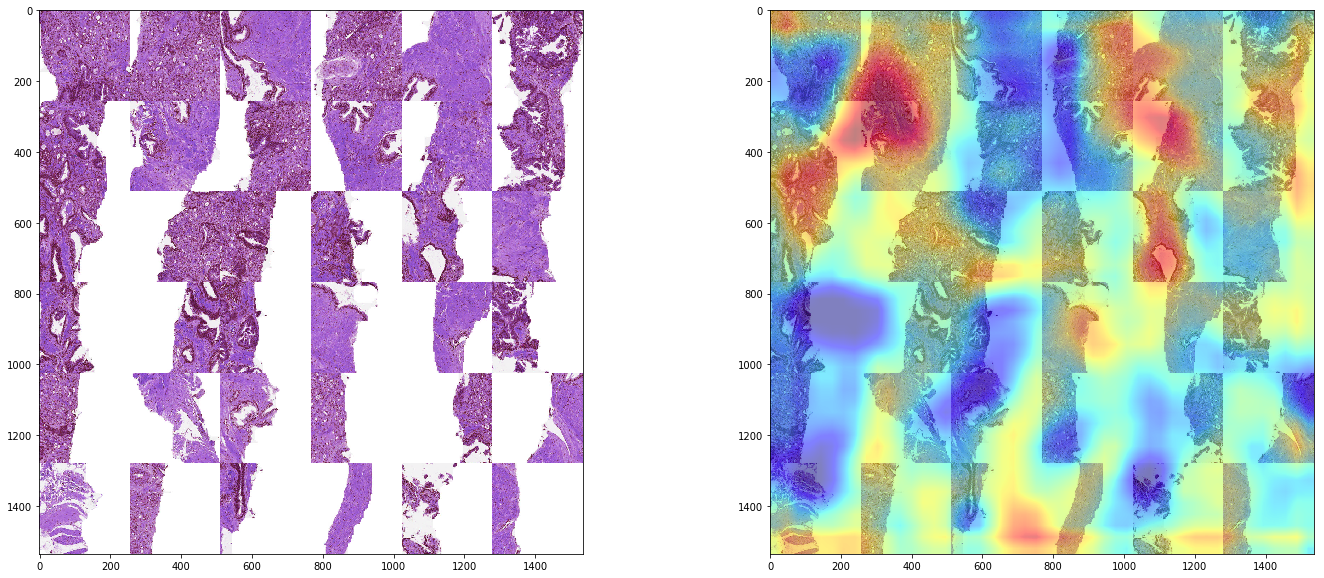

In [29]:
img_id = '6a523275e30b19c0390655b278716b58'
show_gradcam(model, img_id)

In [21]:
val_x['diff'] = np.abs(val_x['isup_grade'] - val_x['oof'])

/home/naoki/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
val_x

,image_id,data_provider,isup_grade,gleason_score,oof,diff
697,11c5d0603ad03546001b684977df9993,karolinska,0,0+0,2,2
3556,596e117592870bc53e8442cc9ff4dcbc,karolinska,0,0+0,5,5
4255,6a523275e30b19c0390655b278716b58,karolinska,5,4+5,1,4
7224,b084fef2354fe904f2279fa7d376855b,karolinska,1,3+3,2,1
8947,d94046cd69c8102ff1e1a871077c7984,radboud,5,4+5,5,0
...,...,...,...,...,...,...
10525,ff0cd440f339e63b75eb835431a593cc,karolinska,0,0+0,3,3
6518,9fdc67635e14822c347061fd50f40939,radboud,5,4+5,0,5
3032,4c9cb3b8e0f18845b3911cdc31d6fa94,radboud,4,4+4,5,1
3376,54d6c9c73ffff3037136f02ad78da625,radboud,1,3+3,4,3


In [27]:
pd.read_csv('../data/input/tile_sort.csv')

,image_id,tile_idx0,tile_idx1,tile_idx2,tile_idx3,tile_idx4,tile_idx5,tile_idx6,tile_idx7,tile_idx8,...,tile_idx26,tile_idx27,tile_idx28,tile_idx29,tile_idx30,tile_idx31,tile_idx32,tile_idx33,tile_idx34,tile_idx35
0,0005f7aaab2800f6170c399693a96917,16,17,13,10,29,23,1,5,7,...,3,0,26,9,21,24,33,20,18,27
1,000920ad0b612851f8e01bcc880d9b3d,13,24,8,7,25,2,9,22,10,...,23,31,20,27,35,1,26,33,0,32
2,0018ae58b01bdadc8e347995b69f99aa,13,10,8,4,7,2,15,9,3,...,21,24,17,11,5,33,27,35,23,29
3,001c62abd11fa4b57bf7a6c603a11bb9,15,9,33,12,26,34,32,3,28,...,35,23,14,29,4,17,5,24,30,11
4,001d865e65ef5d2579c190a0e0350d8f,16,20,10,7,13,9,26,25,32,...,3,2,8,14,21,12,35,18,17,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31,10,18,25,24,28,23,19,4,7,...,1,17,12,29,26,35,5,3,6,0
10612,ffdc59cd580a1468eac0e6a32dd1ff2d,8,22,9,13,10,27,7,14,21,...,29,31,18,33,32,30,17,5,35,0
10613,ffe06afd66a93258f8fabdef6044e181,31,8,1,13,34,28,7,25,33,...,5,3,27,24,17,9,29,16,15,23
10614,ffe236a25d4cbed59438220799920749,11,10,9,12,4,6,3,5,30,...,29,0,27,18,19,22,34,32,33,35
